## Project Graham
 
 [Give an explanation]

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn

from torch.utils.data import DataLoader, TensorDataset

### Electrophysiology / Data Structure Background

Data has already been curated through kilosort, which the model will train on to limit complexity.


Sample Frequency: 20000.0


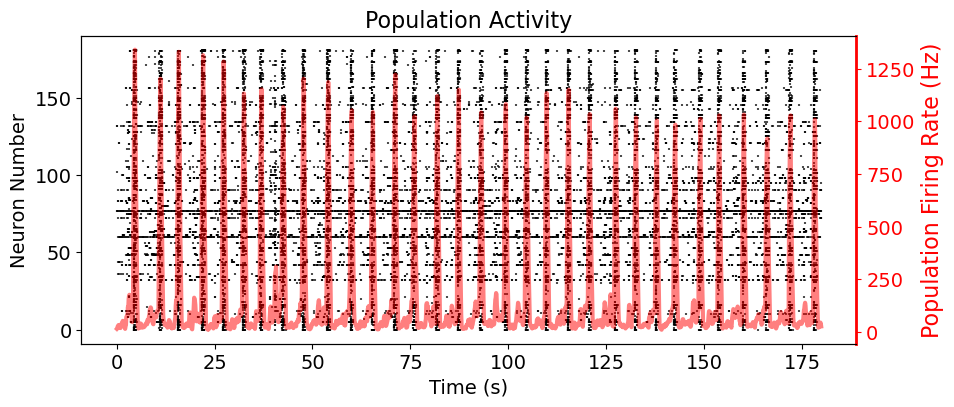

In [2]:
'''
Load in the curated EPhys Data as npz object 
  Data Structure:
    train: 
        Format: {neuron, [associated spike times]}
        Explanation: For each neuron, there is an associated list of spike times
    neuron_data: 
        Format: {neuron, [associated data]}
        Explanation: For each neuron, list of associated data (spatial coordinates, etc.)
    redundant_pairs: literally that
        Format: {neuron, [associated redundant pairs]}
        Explanation: For each neuron, list of associated redundant
    fs: sampling rate
        Format: int
        Explanation: Sampling rate of the data
'''
fname = "data.npz"
data = np.load(fname, allow_pickle=True)

# # Uncomment to see formatting
# print(data.files)
# print(f"trains's type is: {type(data['train'])}")
# print(f"neuron_data's type is: {type(data['neuron_data'])}")
# print(f"redundant_pairs's type is: {type(data['redundant_pairs'])}")
# print(f"fs's type is: {type(data['fs'])}")

# .item() to extract the dictionary from the npz object
neuron_data = data["neuron_data"].item()  # additional information (positional)
sample_freq = data['fs']                  # fs = frequency sample
print(f"Sample Frequency: {sample_freq}")
spike_train = data['train'].item()        # train = spike times

normalized_train = [times/sample_freq for neuron_ID, times in spike_train.items()]
# We now have a list of neurons, each with associated spike times

def get_population_fr(trains: list, bin_size=0.1, w=5):
    ''' Bin population frequencies by time '''
    trains = np.hstack(trains)
    rec_length = np.max(trains)
    bin_num = int(rec_length// bin_size) + 1
    bins = np.linspace(0, rec_length, bin_num)
    fr = np.histogram(trains, bins)[0] / bin_size
    fr_avg = np.convolve(fr, np.ones(w), 'same') / w
    return bins[1:], fr_avg

# Plot Setup
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs1 = axs.twinx()

# Plot population
bins, fr_avg = get_population_fr(trains=normalized_train)
axs1.plot(bins, fr_avg, color='r', linewidth=3, alpha=0.5)

# Plot individual neurons
y = 0
for train in normalized_train:
    axs.scatter(train, [y]*len(train), marker="|", c='k', s=4, alpha=0.7)
    y += 1

# Individual neuron plot
axs.set_title("Population Activity", fontsize=16)
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Neuron Number", fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)

# Population plot
axs1.set_ylabel("Population Firing Rate (Hz)", fontsize=16, color='r')
axs1.set_xlabel("Time (s)", fontsize=14)
axs1.spines['right'].set_color('r')
axs1.spines['right'].set_linewidth(2)
axs1.tick_params(axis='y', colors='r')
axs1.yaxis.set_tick_params(labelsize=14)

### So, How do we quantify characteristics of the data?  *** WIP ***

Spike Timing:
	- ISI Distribution
Firing Rates:
		- Mean firing rates
		- Stochasticity quantification
Population Dynamics:
		* Raster plot
Oscillatory Dynamics:
		- Phase locking
		- Rayleigh test for assessing theta/gamma phase dist.

In [ ]:
# < CODE HERE >

### Cool. Now that we have an idea of what the data is, and how we can analyze it, let's get started with the Spiking Neuron Model    

The first thing we need to do is convert the data into a format that can be used by the model. SNNs are trained with 
binary spike trains, so we need to convert the data into binary spikes.

In [3]:
# I was trying to create a dense matrix, but too slow so I'm going to use sparse representation

def spike_train_to_binary(spike_train, spike_freq):
    '''
    Converts spike times to binary spikes in a torch tensor.

    Parameters:
        spike_train: dict of {neuron: [spike times]}
        spike_freq: sampling frequency (Hz)

    Returns:
        binary_spikes: Binary spike tensor [time, batch_size, num_neurons]
    '''

    # Constants
    num_neurons = len(spike_train)
    dt = 1 / spike_freq
    max_time = max([max(times) for times in spike_train.values()])  # Max spike time
    time_bins = int(max_time / dt) + 1  # Number of bins

    # Initialize binary spike matrix
    binary_spikes = np.zeros((num_neurons, time_bins))

    # Populate binary spike matrix
    for i, (neuron, spike_times) in enumerate(spike_train.items()):
        spike_bins = [int(time // dt) for time in spike_times]  # Find bins for spike times
        spike_bins = [min(bin_idx, time_bins - 1) for bin_idx in spike_bins]  # Clip to time_bins
        binary_spikes[i, spike_bins] = 1  # Set spikes to 1

    # Convert to PyTorch tensor and reshape
    binary_spikes = torch.tensor(binary_spikes, dtype=torch.float32)  # Convert to Tensor
    binary_spikes = binary_spikes.unsqueeze(0).permute(2, 0, 1)  # Reshape to [time, batch, neurons]

    return binary_spikes

# Print total number of spikes
# num_spikes = sum([len(times) for times in spike_train.values()])
# print(f"Total number of spikes: {num_spikes}")
# Remove times after 1 second
# shortened_spike_train = {neuron: [time for time in times if time <= 100000] for neuron, times in spike_train.items()}
# Print total number of spikes after removing times after 1 second
# num_spikes_shortened = sum([len(times) for times in shortened_spike_train.values()])
# print(f"Total number of spikes after removing times after 1 second: {num_spikes_shortened}")
# print(num_spikes_shortened)
# Convert spike train to binary spikes
# binary_spike_train_tensor = spike_train_to_binary(spike_train=shortened_spike_train, spike_freq=sample_freq)

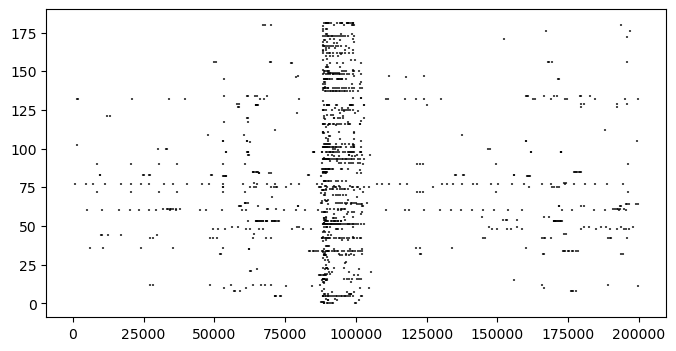

In [12]:
### Create smaller dataset for testing (5 seconds)

def shorten_spike_train(orig_data, sample_freq, max_time_seconds, remove_n_neurons=0):
    ''' Shorten spike train dict to max time in seconds'''

    time_conv = max_time_seconds * sample_freq
    shortened_data = {}

    while remove_n_neurons > 0:
        remove_n_neurons -= 1
        orig_data.popitem()
    for neuron, times in orig_data.items():
        shortened_data[neuron] = [time for time in times if time <= time_conv]
    total_spikes = sum([len(times) for times in shortened_data.values()])

    return shortened_data, total_spikes

# Shorten spike train
shortened_data, total_spikes = shorten_spike_train(spike_train, sample_freq, 10)

# Plot
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
y = 0
for train in shortened_data.values():
    axs.scatter(train, [y]*len(train), marker="|", c='k', s=4, alpha=0.7)
    y += 1


In [29]:
# Ensure the spike train is structured correctly
spike_train = shortened_data
num_neurons = len(spike_train)
spike_freq = sample_freq  # Hz
dt = 1 / spike_freq  # Time step in seconds
time_bins = int(spike_freq * 10)  # Number of time bins (10 seconds)

# Map neuron IDs to indices
neuron_map = {neuron: idx for idx, neuron in enumerate(sorted(spike_train.keys()))}

# Create a list of spike events (time_bin, neuron_index)
sparse_spikes = []
for neuron, times in spike_train.items():
    for time in times:
        time_bin = int(time / dt)
        if neuron in neuron_map:
            sparse_spikes.append((time_bin, neuron_map[neuron]))  
sparse_spikes = sorted(sparse_spikes, key=lambda x: x[0])  # Sort by time_bin

# Quantize to bins
spikes_in_bins = [(int(time / dt), neuron_idx) for time, neuron_idx in sparse_spikes]
spikes_in_bins = sorted(spikes_in_bins, key=lambda x: x[0])  # Sort by time bin

# Create tensor of spike events (shape: time_bins x num_neurons)
spike_events = torch.zeros(time_bins, num_neurons)

# Fill in spike events
for time_bin, neuron_idx in spikes_in_bins:
    if time_bin < time_bins:
        spike_events[time_bin, neuron_idx] = 1

# Create DataLoader
dataset = TensorDataset(spike_events)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

class GenerativeSNN(nn.Module):
    def __init__(self, num_neurons):
        super(GenerativeSNN, self).__init__()
        self.lif1 = snn.Leaky(beta=0.9)  # Hidden layer
        self.lif2 = snn.Leaky(beta=0.9)  # Output layer
        self.fc1 = nn.Linear(num_neurons, num_neurons)  # Input to hidden
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden to output

    def forward(self, input_spikes):
        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()  # Membrane potential for layer 1
        mem2 = self.lif2.init_leaky()  # Membrane potential for layer 2

        # Initialize the output to store spike events
        output = torch.zeros_like(input_spikes)

        for time_bin in range(input_spikes.size(0)):  # Loop over time bins
            spikes_at_time = input_spikes[time_bin]  # Spike events at this time bin

            # Update the hidden layer using the spikes at this time bin
            hidden, mem1 = self.lif1(self.fc1(spikes_at_time), mem1)
            # Update the output layer using the hidden layer output
            output_spikes, mem2 = self.lif2(self.fc2(hidden), mem2)

            # Store output spikes (you could apply a threshold here if needed)
            output[time_bin] = output_spikes

        return output

# Initialize SNN model
model = GenerativeSNN(num_neurons)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()

        # Get the spike events (time_bins x num_neurons)
        spike_input = batch[0]

        # Forward pass through the model
        output_spikes = model(spike_input)

        # Compute the loss (Mean Squared Error between the input and the output spikes)
        loss = criterion(output_spikes, spike_input)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Print loss
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# Lets start with a simple LIF model

# SELF NOTE: Can we quantify the performance of using SNN vs normal NN for temporal data?
# SELF NOTE: Can we add spatial components to the SNN model?

class SimpleLeakySNN(nn.Module):
    '''
    Simple Leaky Integrate-and-Fire (LIF) SNN Model
    Input dimensionality: [time, batch_size, input_neurons]
    '''
    def __init__(self, 
                 num_input_neurons, 
                 num_hidden_neurons, 
                 num_output_neurons, 
                 num_steps, 
                 beta_hidden=0.9, 
                 beta_output=0.9):
        super(SimpleLeakySNN, self).__init__()

        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
        self.num_steps = num_steps

        # Define layers
        self.fully_connected_1 = nn.Linear(num_input_neurons, num_hidden_neurons)
        self.lif_hidden_layer1 = snn.Leaky(beta=beta_hidden)

        self.fully_connected_2 = nn.Linear(num_hidden_neurons, num_output_neurons)
        self.lif_output_layer = snn.Leaky(beta=beta_output)

    def forward(self, input):
        batch_size = input.size(1)

        # Initialize membrane potentials
        mem_hidden = self.lif_hidden_layer1.init_leaky()
        mem_output = self.lif_output_layer.init_leaky()

        # Output spikes across time
        output_spikes = torch.zeros(self.num_steps, batch_size, self.num_output_neurons)

        # Forward pass
        for step in range(self.num_steps):

            # Hidden layer
            current_hidden = self.fully_connected_1(input[step])
            spike_hidden, mem_hidden = self.lif_hidden_layer1(current_hidden, mem_hidden)

            # Output layer
            current_output = self.fully_connected_2(spike_hidden)
            spike_output, mem_output = self.lif_output_layer(current_output, mem_output)

            output_spikes[step] = spike_output  # Store spikes

        return output_spikes
